## Packages

In [6]:
!pip install fastai -Uqq

In [2]:
from fastai.vision.all import *
from torch.optim import AdamW
from tqdm import tqdm

## Download dataset

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = "lkarjun"
os.environ['KAGGLE_KEY'] = "-"

In [ ]:
!kaggle datasets download -d duttadebadri/image-classification
!unzip image-classification.zip -d images

In [5]:
dataset_path = Path("images/images/images")

## Here we go

### Dataloader

In [25]:
def get_fnames(dataset_path, folders: list, n_files = 400):
    fnames = []
    full_fnames = []
    for folder in folders:
        files = get_image_files(dataset_path/folder).shuffle()
        full_fnames += files[n_files:]
        fnames += files[:n_files]
    return fnames, full_fnames

In [26]:
fnames, full_fnames = get_fnames(dataset_path, ['architecure', 'art and culture'])

len(fnames), len(full_fnames)

(800, 16713)

In [27]:
BATCH_SIZE = 64
RESIZE = 224

def get_dls(fnames):
    dls = ImageDataLoaders.from_path_func(
                dataset_path, 
                fnames, 
                parent_label,
                batch_tfms = Normalize.from_stats(*imagenet_stats), 
                item_tfms = Resize(RESIZE), 
                bs=BATCH_SIZE
              )
    return dls

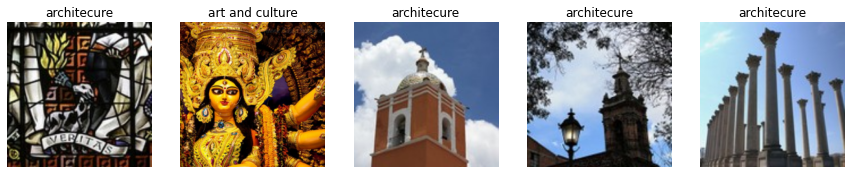

In [28]:
dls = get_dls(fnames)

dls.show_batch(max_n = 5, nrows=1)

In [29]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

### Model

In [30]:
body = create_body(resnet50, cut=-2)

In [31]:
head = create_head(nf = num_features_model(body), 
                   lin_ftrs=[512, 128],
                   n_out = 2, 
                   concat_pool=False, 
                   pool=True)
head

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.25, inplace=False)
  (8): Linear(in_features=512, out_features=128, bias=False)
  (9): ReLU(inplace=True)
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=128, out_features=2, bias=False)
)

In [32]:
class RImgModel(Module):
    def __init__(self, body,head):
        self.body = body
        self.head = head
    
    def forward(self, x):
        x = self.body(x)
        return self.head(x)

In [33]:
model = RImgModel(body, head).cuda()

In [34]:
def model_splitter(model):
    return L(model.body, model.head).map(params)

In [35]:
learn = Learner(dls, model,
                splitter = model_splitter, 
                metrics=accuracy)

In [36]:
learn.freeze()

In [37]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.307760,0.091534,1.000000,00:04
1,0.156862,0.006510,1.000000,00:04
2,0.099381,0.005226,1.000000,00:04
3,0.069759,0.004382,1.000000,00:04


In [39]:
# lower lr for body and high for head
learn.unfreeze()

learn.fit_one_cycle(1, slice(1e-7,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.009599,0.001037,1.000000,00:04


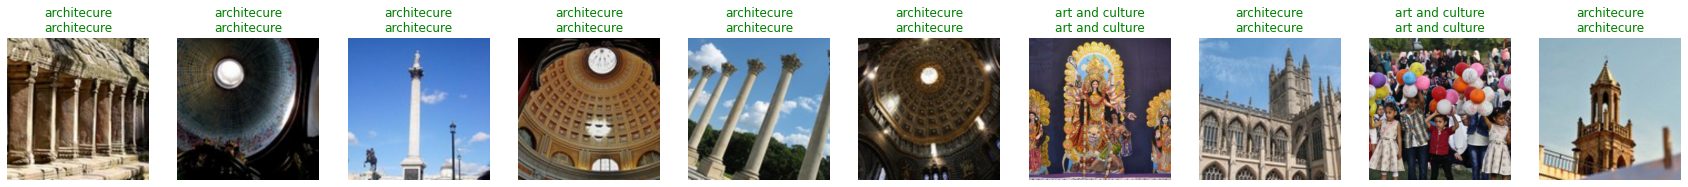

In [42]:
learn.show_results(max_n = 10, nrows=1)

### Geting feature vector

In [43]:
def get_feature_vector(learn, X = None, dl = None):
    with hook_output(learn.model.head[8]) as h:
        if dl is not None:
            y = learn.get_preds(dl=dl)
        else:
            y = learn.predict(X)
    return h.stored

In [44]:
def process_batch(fnames, learn):
    features = []
    dl = learn.dls.test_dl(fnames)
    for i in tqdm(range(0, len(fnames), BATCH_SIZE)):
        names = fnames[i:i + BATCH_SIZE]
        dl = learn.dls.test_dl(names)
        features += get_feature_vector(dl = dl, learn = learn)

    features = torch.stack(features, dim = 0).cpu().numpy()
    return features

In [45]:
full_fnames_ = full_fnames.shuffle()[:1200]

features = process_batch(full_fnames_, learn)

  0%|                                                              | 0/19 [00:00<?, ?it/s]

  5%|██▊                                                   | 1/19 [00:01<00:18,  1.04s/it]

 11%|█████▋                                                | 2/19 [00:02<00:18,  1.06s/it]

 16%|████████▌                                             | 3/19 [00:03<00:17,  1.09s/it]

 21%|███████████▎                                          | 4/19 [00:04<00:17,  1.15s/it]

 26%|██████████████▏                                       | 5/19 [00:05<00:16,  1.16s/it]

 32%|█████████████████                                     | 6/19 [00:08<00:20,  1.57s/it]

 37%|███████████████████▉                                  | 7/19 [00:09<00:16,  1.41s/it]

 42%|██████████████████████▋                               | 8/19 [00:10<00:15,  1.38s/it]

 47%|█████████████████████████▌                            | 9/19 [00:11<00:13,  1.34s/it]

 53%|███████████████████████████▉                         | 10/19 [00:13<00:12,  1.38s/it]

 58%|██████████████████████████████▋                      | 11/19 [00:14<00:10,  1.31s/it]

 63%|█████████████████████████████████▍                   | 12/19 [00:15<00:08,  1.23s/it]

 68%|████████████████████████████████████▎                | 13/19 [00:16<00:07,  1.24s/it]

 74%|███████████████████████████████████████              | 14/19 [00:17<00:06,  1.21s/it]

 79%|█████████████████████████████████████████▊           | 15/19 [00:18<00:04,  1.21s/it]

 84%|████████████████████████████████████████████▋        | 16/19 [00:20<00:03,  1.19s/it]

 89%|███████████████████████████████████████████████▍     | 17/19 [00:21<00:02,  1.19s/it]

 95%|██████████████████████████████████████████████████▏  | 18/19 [00:22<00:01,  1.15s/it]

100%|█████████████████████████████████████████████████████| 19/19 [00:23<00:00,  1.24s/it]


In [46]:
features.shape

(1200, 128)

### Similar Images

In [47]:
from sklearn.neighbors import NearestNeighbors

def get_neighbor(features):
    neighbors = NearestNeighbors(n_neighbors=10, algorithm='brute',metric='cosine')
    return neighbors.fit(features)

In [48]:
neighbors = get_neighbor(features)

In [49]:
def plot_similar(axs, ids, distances):
    for i, ax, idx_, dis in zip(range(10), axs, ids, distances):
        img = Image.open(full_fnames_[idx_])
        ax.imshow(img)
        ax.set_title(dis)

In [50]:
def plot_similar_images(idx, fname):
    
    feature = get_feature_vector(learn, fname).cpu()
    
    distances, idxs = neighbors.kneighbors(feature, n_neighbors=10)
    plt.imshow(Image.open(fname))
    plt.title(f"Sample Image: {fname.parent.name}")

    fig, axs = plt.subplots(2,5, figsize=(15, 10))

    plot_similar(axs.flatten(), idxs[0], distances[0])
    
    return feature, fname

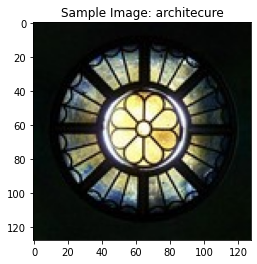

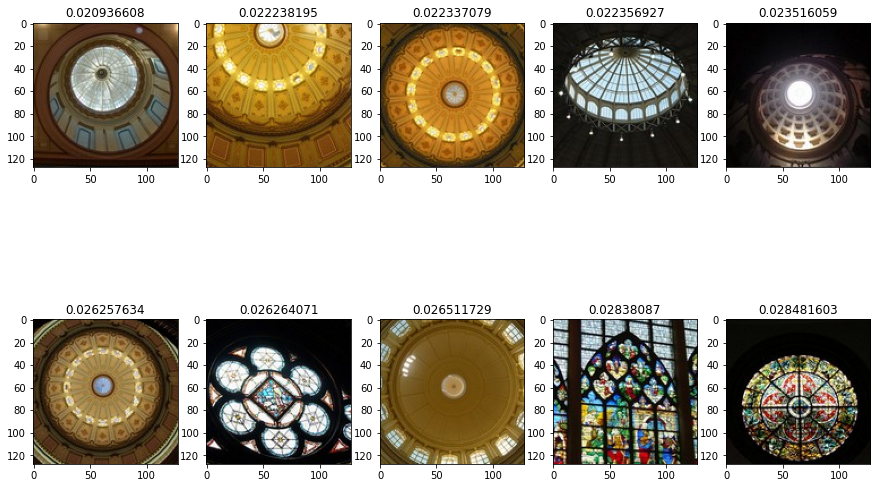

In [52]:
f_, fn = plot_similar_images(1, fnames[100])

### Filter by distances

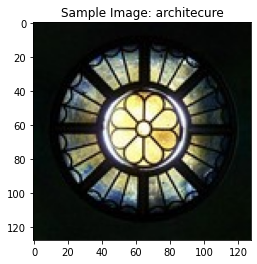

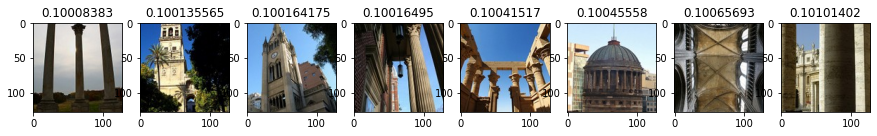

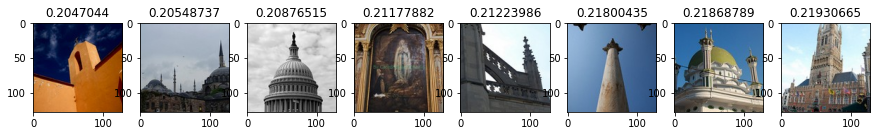

In [53]:
threshs = [(.1, .2), (.2, .5)]

plt.imshow(Image.open(fn))
plt.title(f"Sample Image: {fn.parent.name}")

for i, thresh in enumerate(threshs):    
    distances, idxs = neighbors.kneighbors(f_, n_neighbors=len(features))

    distances_ = distances[(distances >= thresh[0]) & (distances <= thresh[1])]
    idxs_ = idxs[(distances >= thresh[0]) & (distances <= thresh[1])]

    fig, axs = plt.subplots(1,8 if len(distances_) >= 8 else len(distances_), 
                            figsize=(15, 10))

    plot_similar(axs.flatten(), idxs_.flatten(), distances_.flatten())

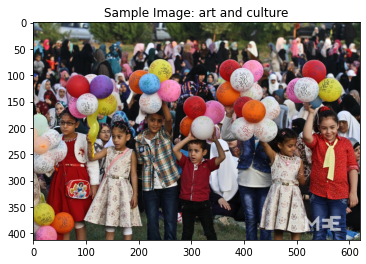

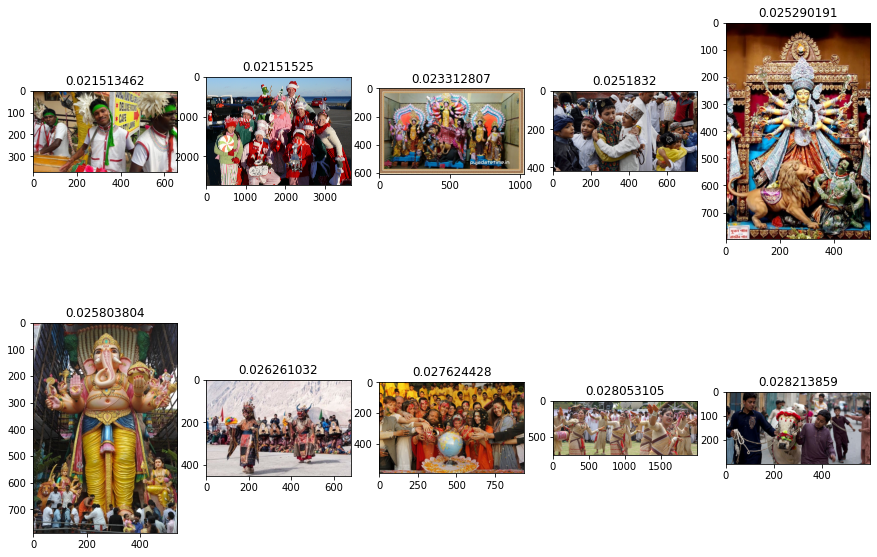

In [ ]:
f_, fn = plot_similar_images(1, fnames[417])

### Filter by distances

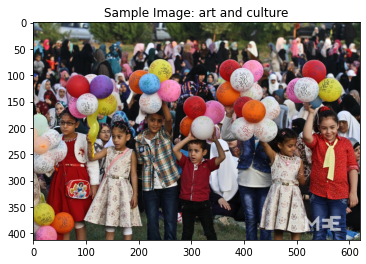

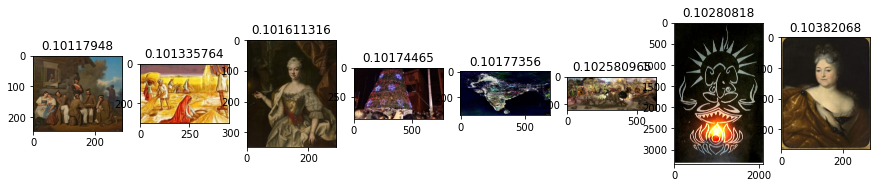

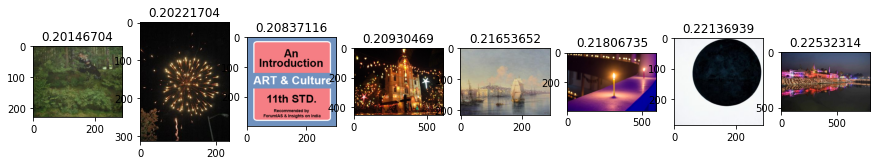

In [73]:
threshs = [(.1, .2), (.2, .5)]

plt.imshow(Image.open(fn))
plt.title(f"Sample Image: {fn.parent.name}")

for i, thresh in enumerate(threshs):    
    distances, idxs = neighbors.kneighbors(f_, n_neighbors=len(features))

    distances_ = distances[(distances >= thresh[0]) & (distances <= thresh[1])]
    idxs_ = idxs[(distances >= thresh[0]) & (distances <= thresh[1])]

    fig, axs = plt.subplots(1,8 if len(distances_) >= 8 else len(distances_), 
                            figsize=(15, 10))

    plot_similar(axs.flatten(), idxs_.flatten(), distances_.flatten())

### Retrain When New Category Added

In [74]:
def get_new_learner(old_learner, dls, lin_ftrs = [512, 128]):
    body = copy(old_learner.model.body)
    head = create_head(nf = num_features_model(body), 
                       lin_ftrs=lin_ftrs,
                       n_out = dls.c, 
                       concat_pool=False, 
                       pool=True)

    model = RImgModel(body, head).cuda()
    learn = Learner(dls, model,
                      splitter = model_splitter, 
                      metrics=[accuracy, error_rate])
    learn.freeze()
    return learn

In [75]:
fnames, full_fnames = get_fnames(dataset_path, ['architecure', 'art and culture', 'travel and  adventure'], 400)

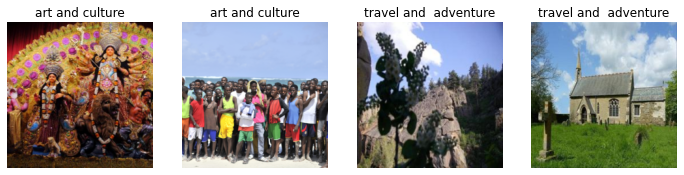

In [80]:
dls = get_dls(fnames)

dls.show_batch(max_n = 4, nrows = 1)

In [85]:
new_learner = get_new_learner(learn, dls)

In [308]:
new_learner.summary()

RImgModel (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                         

In [86]:
new_learner.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.323116,0.129182,0.958333,0.041667,00:06
1,0.148727,0.074283,0.979167,0.020833,00:05
2,0.086505,0.059243,0.979167,0.020833,00:05
3,0.058718,0.051953,0.983333,0.016667,00:05


In [87]:
# lower lr for body and high for head
learn.unfreeze()

learn.fit_one_cycle(1, slice(1e-7,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.004390,0.008300,0.993750,00:05
